Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///workspace/finn-base
  Running setup.py develop for finn-base


# End-to-End FINN Flow for a Simple Convolutional Net
-----------------------------------------------------------------

In this notebook, we will go through the FINN steps needed to take a binarized convolutional network all the way down to a heterogeneous streaming dataflow accelerator running on the FPGA. 

It's recommended to go through the simpler [end-to-end notebook for a fully connected network](tfc_end2end_example.ipynb) first, since many steps here are very similar and we will focus on what is done differently for convolutions.

This notebook is quite lengthy, and some of the cells (involving Vivado synthesis) may take up to an hour to finish running. To let you save and resume your progress, we will save the intermediate ONNX models that are generated in the various steps to disk, so that you can jump back directly to where you left off.

## Quick Introduction to the CNV-w1a1 Network

The particular quantized neural network (QNN) we will be targeting in this notebook is referred to as CNV-w1a1 and it classifies 32x32 RGB images into one of ten CIFAR-10 classes. All weights and activations in this network are quantized to bipolar values (either -1 or +1), with the exception of the input (which is RGB with 8 bits per channel) and the final output (which is 32-bit numbers). It first appeared in the original [FINN paper](https://arxiv.org/abs/1612.07119) from ISFPGA'17 with the name CNV, as a variant of the binarized convolutional network from the [BinaryNet paper](https://arxiv.org/abs/1602.02830), in turn inspired by the VGG-11 topology which was the runner-up for the 2014 [ImageNet Large Scale Visual Recognition Challenge](http://www.image-net.org/challenges/LSVRC/).


You'll have a chance to interactively examine the layers that make up the network in Netron in a moment, so that's enough about the network for now. 

## Quick Recap of the End-to-End Flow

The FINN compiler comes with many *transformations* that modify the ONNX representation of the network according to certain patterns. This notebook will demonstrate a *possible* sequence of such transformations to take a particular trained network all the way down to hardware, as shown in the figure below.

![](finn-design-flow-example.svg)

The white fields show the state of the network representation in the respective step. The colored fields represent the transformations that are applied to the network to achieve a certain result. The diagram is divided into 5 sections represented by a different color, each of it includes several flow steps. The flow starts in top left corner with Brevitas export (green section), followed by the preparation of the network (blue section) for the Vivado HLS synthesis and Vivado IPI stitching (orange section), and finally building a PYNQ overlay bitfile and testing it on a PYNQ board (yellow section).
There is an additional section for functional verification (red section) on the left side of the diagram, which we will not cover in this notebook. For details please take a look in the verification notebook which you can find [here](tfc_end2end_verification.ipynb)


We will use the helper function `showInNetron` to show the ONNX model at the current transformation step. The Netron displays are interactive, but they only work when running the notebook actively and not on GitHub (i.e. if you are viewing this on GitHub you'll only see blank squares).

In [1]:
from finn.util.basic import make_build_dir
from finn.util.visualization import showInNetron
from finn.core.modelwrapper import ModelWrapper
from os.path import join
import numpy as np
    

EXPORT_NAME = 'finnlayer_4w4a'
# EXPORT_NAME = 'yolo_finn_6conv_4w4a_VOT_VTB'

build_dir = join(EXPORT_NAME, 'onnxs')

## 1. Brevitas Export, FINN Import and Tidy-Up

Similar to what we did in the TFC-w1a1 end-to-end notebook, we will start by exporting the [pretrained CNV-w1a1 network](https://github.com/Xilinx/brevitas/tree/master/brevitas_examples/bnn_pynq) to ONNX, importing that into FINN and running the "tidy-up" transformations to have a first look at the topology.

In [1]:
!pip list

Package                           Version                  Location
--------------------------------- ------------------------ --------------------------------
alabaster                         0.7.12
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
attrs                             19.3.0
Babel                             2.9.1
backcall                          0.2.0
backports.entry-points-selectable 1.1.1
beautifulsoup4                    4.9.3
bitstring                         3.1.7
bleach                            4.1.0
brevitas                          0.6.1.dev89+ga5b71d6     /workspace/brevitas/src
brotlipy                          0.7.0
cachetools                        4.2.4
certifi                           2021.10.8
cffi                              1.14.3
cfgv                              3.3.1
chardet                           3.0.4
clize                             4.1.1
conda                             4.9.2
conda-build                 

In [9]:
import onnx
import torch
from finn.util.test import get_test_model_trained
import brevitas.onnx as bo
from finn.core.modelwrapper import ModelWrapper
from finn.transformation.infer_shapes import InferShapes
from finn.transformation.fold_constants import FoldConstants
from finn.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs
import torchvision.transforms as transforms

from finnmodels import get_pretrained_backbone, get_CNVmy
from finn_models import get_finnlayer


# def test_preprocess(data):
#     return torch.tensor(data).float() / 255.0


def test_preprocess(data):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    result = transform(data)
    result = result.unsqueeze(dim=0)

    return result


brevitas_model = get_finnlayer(join(EXPORT_NAME, 'savegame_0_15000.pth.tar'), w_a_bitwidths=(4, 4), load_weights=True, strict=False)
# brevitas_model = get_test_model_trained("CNV", 1, 1)
# brevitas_model = get_pretrained_backbone(join(EXPORT_NAME, 'config.json'), join(EXPORT_NAME, 'test_best.pt'), pretrained=False)
# brevitas_model = get_CNVmy(join(EXPORT_NAME, 'model.pt'), convonly=True, pretrained=False)
# torch.save(brevitas_model.state_dict(), join(EXPORT_NAME, 'random_model.pt'))

# brevitas_model.load_state_dict(torch.load(join(EXPORT_NAME, 'random_model.pt')))

print(type(brevitas_model))
test_input = np.load(join(EXPORT_NAME, 'test_input.npy'))
# test_input = np.random.rand(1, 3, 224, 224)
# np.save(join(EXPORT_NAME, 'input.npy'), test_input)
print(test_input)

test_input = test_preprocess(test_input)
print('input shape:', test_input.shape)

test_output = brevitas_model(test_input)
print('test output:', test_output.shape)
print(test_output[0, 0])

bo.export_finn_onnx(brevitas_model, (1, 3, 224, 224), join(build_dir, EXPORT_NAME + "_export.onnx"))
model = ModelWrapper(join(build_dir, EXPORT_NAME + "_export.onnx"))
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(RemoveStaticGraphInputs())
model.save(join(build_dir, EXPORT_NAME + "_tidy.onnx"))

<class 'finn_models.FINNLayer'>
[[[ 98 100 101]
  [ 97  99 100]
  [ 95  97  98]
  ...
  [221 237 249]
  [220 235 245]
  [219 234 243]]

 [[ 96  98  99]
  [ 94  96  97]
  [ 91  92  93]
  ...
  [224 240 252]
  [222 238 250]
  [222 237 248]]

 [[ 93  95  97]
  [ 90  92  94]
  [ 86  87  89]
  ...
  [226 244 255]
  [225 242 254]
  [225 241 253]]

 ...

 [[223 236 252]
  [223 236 252]
  [223 236 252]
  ...
  [160 127 114]
  [159 127 113]
  [159 126 113]]

 [[223 234 251]
  [223 234 251]
  [223 234 251]
  ...
  [153 123 111]
  [156 127 114]
  [158 130 117]]

 [[223 233 250]
  [223 233 250]
  [223 233 250]
  ...
  [145 119 107]
  [152 128 116]
  [158 134 122]]]
input shape: torch.Size([1, 3, 224, 224])
test output: torch.Size([1, 64, 112, 112])
tensor([[0.8471, 0.2353, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 0.3569, 0.0000,  ..., 0.2745, 0.2745, 1.0000],
        [1.0000, 0.4784, 0.0000,  ..., 0.2745, 0.2745, 1.0000],
        ...,
        [0.2745, 0.2745, 0.2745,  ..., 0.3373, 0

Now that the model is exported, let's have a look at its layer structure with Netron. Remember that the visualization below is interactive, you can click on the individual nodes and view the layer attributes, trained weights and so on.

In [3]:
showInNetron(join(build_dir, EXPORT_NAME + "_tidy.onnx"))

Serving 'finnlayer/onnxs/finnlayer_tidy.onnx' at http://0.0.0.0:8081


You can see that the network is composed of a repeating convolution-convolution-maxpool layer pattern to extract features using 3x3 convolution kernels (with weights binarized) and `Sign` activations, followed by fully connected layers acting as the classifier. Also notice the initial `MultiThreshold` layer at the beginning of the network, which is quantizing float inputs to 8-bit ones.

### Adding Pre- and Postprocessing <a id='prepost'></a>

TODO

In [5]:
import torch

from finn.util.pytorch import NormalizePreProc, ToTensor
from finn.transformation.merge_onnx_models import MergeONNXModels
from finn.core.datatype import DataType
from finn.transformation.infer_datatypes import InferDataTypes

model = ModelWrapper(join(build_dir, EXPORT_NAME + "_tidy.onnx"))
global_inp_name = model.graph.input[0].name
ishape = model.get_tensor_shape(global_inp_name)
# preprocessing: torchvision's ToTensor divides uint8 inputs by 255
# transform = ToTensor()
transform = NormalizePreProc(mean=[0.485, 0.456, 0.406],
                             std=torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1),
                             channels=3)
chkpt_preproc_name = join(build_dir, EXPORT_NAME + "_preproc.onnx")
bo.export_finn_onnx(transform, ishape, chkpt_preproc_name)

# join preprocessing and core model
pre_model = ModelWrapper(chkpt_preproc_name)
model = model.transform(MergeONNXModels(pre_model))
# add input quantization annotation: UINT8 for all BNN-PYNQ models
global_inp_name = model.graph.input[0].name
model.set_tensor_datatype(global_inp_name, DataType["UINT8"])

# # postprocessing: insert Top-1 node at the end
# model = model.transform(InsertTopK(k=1))
# chkpt_name = join(build_dir, EXPORT_NAME + "_TEST_pre_post.onnx")
chkpt_name = join(build_dir, EXPORT_NAME + "_pre_post.onnx")
# tidy-up again
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(InferDataTypes())
model = model.transform(RemoveStaticGraphInputs())
model.save(chkpt_name)

/workspace/finn-base/src/finn/transformation/infer_data_layouts.py:119: UserWarning: Assuming 4D input is NCHW
  warnings.warn("Assuming 4D input is NCHW")


In [19]:
showInNetron(join(build_dir, EXPORT_NAME + "_pre_post.onnx"))

Stopping http://0.0.0.0:8081
Serving 'finnlayer/onnxs/finnlayer_pre_post.onnx' at http://0.0.0.0:8081


## 2. How FINN Implements Convolutions: Lowering and Streamlining

In FINN, we implement convolutions with the *lowering* approach: we convert them to matrix-matrix multiply operations, where one of the matrices is generated by sliding a window over the input image. You can read more about the sliding window operator and how convolution lowering works [in this notebook](https://github.com/maltanar/qnn-inference-examples/blob/master/3-convolutional-binarized-gtsrb.ipynb). The streaming dataflow architecture we will end up with is going to look something like this figure from the [FINN-R paper](https://arxiv.org/abs/1809.04570):

![](cnv-mp-fc.png)

Note how the convolution layer looks very similar to the fully connected one in terms of the matrix-vector-threshold unit (MVTU), but now the MVTU is preceded by a sliding window unit that produces the matrix from the input image. All of these building blocks, including the `MaxPool` layer you see in this figure, exist as templated Vivado HLS C++ functions in [finn-hlslib](https://github.com/Xilinx/finn-hlslib).


To target this kind of hardware architecture with our network we'll apply a convolution lowering transformation, in addition to streamlining. You may recall the *streamlining transformation* that we applied to the TFC-w1a1 network, which is a series of mathematical simplifications that allow us to get rid of floating point scaling operations by implementing few-bit activations as thresholding operations. **The current implementation of streamlining is highly network-specific and may not work for your network if its topology is very different than the example network here. We hope to rectify this in future releases.**

In [6]:
from finn.transformation.streamline import Streamline
from finn.transformation.lower_convs_to_matmul import LowerConvsToMatMul
from finn.transformation.bipolar_to_xnor import ConvertBipolarMatMulToXnorPopcount
import finn.transformation.streamline.absorb as absorb
from finn.transformation.streamline.reorder import MakeMaxPoolNHWC, MoveScalarLinearPastInvariants
from finn.transformation.infer_data_layouts import InferDataLayouts
from finn.transformation.general import RemoveUnusedTensors

# model = ModelWrapper(join(build_dir, EXPORT_NAME + "_TEST_pre_post.onnx"))
model = ModelWrapper(join(build_dir, EXPORT_NAME + "_pre_post.onnx"))
model = model.transform(MoveScalarLinearPastInvariants())#1
model = model.transform(Streamline())#2
model = model.transform(LowerConvsToMatMul())#3
model.save(join(build_dir, EXPORT_NAME + "_premakemaxpool.onnx"))
# model.save(join(build_dir, EXPORT_NAME + "_TEST_premakemaxpool.onnx"))

In [3]:
showInNetron(join(build_dir, EXPORT_NAME + "_TEST_premakemaxpool.onnx"))

Serving 'finnlayer/onnxs/finnlayer_TEST_premakemaxpool.onnx' at http://0.0.0.0:8081


In [5]:
showInNetron(join(build_dir, EXPORT_NAME + "_premakemaxpool.onnx"))

Serving 'finnlayer/onnxs/finnlayer_premakemaxpool.onnx' at http://0.0.0.0:8081


In [7]:
model = ModelWrapper(join(build_dir, EXPORT_NAME + "_premakemaxpool.onnx"))
# model = ModelWrapper(join(build_dir, EXPORT_NAME + "_TEST_premakemaxpool.onnx"))
model = model.transform(MakeMaxPoolNHWC())#4

model.save(join(build_dir, EXPORT_NAME + "_postmakemaxpool.onnx"))
# model.save(join(build_dir, EXPORT_NAME + "_TEST_postmakemaxpool.onnx"))

model = model.transform(absorb.AbsorbTransposeIntoMultiThreshold())#5
model = model.transform(ConvertBipolarMatMulToXnorPopcount())  #6
model = model.transform(Streamline())#7
# absorb final add-mul nodes into TopK
# model = model.transform(absorb.AbsorbScalarMulAddIntoTopK())    # bo topkek
model = model.transform(InferDataLayouts())#8
model = model.transform(RemoveUnusedTensors())#9
#EXTRA
model = model.transform(MakeMaxPoolNHWC())#4 !!!!!!!EXTRA!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
model = model.transform(Streamline())#7
model = model.transform(InferDataLayouts())#8
model = model.transform(RemoveUnusedTensors())#9
#oraz EXTRA

streamlined_name = join(build_dir, EXPORT_NAME + "_streamlined.onnx")
# streamlined_name = join(build_dir, EXPORT_NAME + "_TEST_streamlined.onnx")
model.save(streamlined_name)
print('Streamlined model saved as ' + streamlined_name)

MAXPOOL NODE:
input: "MultiThreshold_1_out0"
output: "MaxPool_0_out0"
name: "MaxPool_0"
op_type: "MaxPool"
attribute {
  name: "kernel_shape"
  ints: 2
  ints: 2
  type: INTS
}
attribute {
  name: "pads"
  ints: 0
  ints: 0
  ints: 0
  ints: 0
  type: INTS
}
attribute {
  name: "strides"
  ints: 2
  ints: 2
  type: INTS
}

producer:
input: "Conv_0_out0"
input: "MultiThreshold_1_param0"
output: "MultiThreshold_1_out0"
name: "MultiThreshold_1"
op_type: "MultiThreshold"
attribute {
  name: "out_dtype"
  s: "UINT8"
  type: STRING
}
domain: "finn.custom_op.general"

consumer: <class 'onnx.onnx_ONNX_REL_1_7_ml_pb2.NodeProto'>
input: "MaxPool_0_out0"
input: "Mul_0_param0"
output: "global_out"
name: "Mul_0"
op_type: "Mul"

MAXPOOL NODE:
input: "Transpose_1_out0"
output: "MaxPool_0_out0"
name: "MaxPool_0"
op_type: "MaxPool"
attribute {
  name: "kernel_shape"
  ints: 2
  ints: 2
  type: INTS
}
attribute {
  name: "pads"
  ints: 0
  ints: 0
  ints: 0
  ints: 0
  type: INTS
}
attribute {
  name: "

In [8]:
showInNetron(join(build_dir, EXPORT_NAME + "_TEST_postmakemaxpool.onnx"))

Stopping http://0.0.0.0:8081
Serving 'finnlayer/onnxs/finnlayer_TEST_postmakemaxpool.onnx' at http://0.0.0.0:8081


In [6]:
showInNetron(join(build_dir, EXPORT_NAME + "_postmakemaxpool.onnx"))

Serving 'finnlayer/onnxs/finnlayer_postmakemaxpool.onnx' at http://0.0.0.0:8081


We won't go into too much detail about what happens in each transformation and why they are called in the particular order they are (feel free to visualize the intermediate steps using Netron yourself if you are curious) but here is a brief summmmary:

* `Streamline` moves floating point scaling and addition operations closer to the input of the nearest thresholding activation and absorbs them into thresholds
* `LowerConvsToMatMul` converts ONNX `Conv` nodes into sequences of `Im2Col, MatMul` nodes as discussed above. `Im2Col` is a custom FINN ONNX high-level node type that implements the sliding window operator.
* `MakeMaxPoolNHWC` and `AbsorbTransposeIntoMultiThreshold` convert the *data layout* of the network into the NHWC data layout that finn-hlslib primitives use. NCHW means the tensor dimensions are ordered as `(N : batch, H : height, W : width, C : channels)` (assuming 2D images). The ONNX standard ops normally use the NCHW layout, but the ONNX intermediate representation itself does not dictate any data layout.
* You may recall `ConvertBipolarMatMulToXnorPopcount` from the TFC-w1a1 example, which is needed to implement bipolar-by-bipolar (w1a1) networks correctly using finn-hlslib.

Let's visualize the streamlined and lowered network with Netron. Observe how all the `Conv` nodes have turned into pairs of `Im2Col, MatMul` nodes, and many nodes including `BatchNorm, Mul, Add` nodes have disappeared and replaced with `MultiThreshold` nodes.

In [29]:
showInNetron(join(build_dir, EXPORT_NAME + "_streamlined.onnx"))

Stopping http://0.0.0.0:8081
Serving 'finnlayer/onnxs/finnlayer_streamlined.onnx' at http://0.0.0.0:8081


In [9]:
showInNetron(join(build_dir, EXPORT_NAME + "_TEST_streamlined.onnx"))

Stopping http://0.0.0.0:8081
Serving 'finnlayer/onnxs/finnlayer_TEST_streamlined.onnx' at http://0.0.0.0:8081


## 3. Partitioning, Conversion to HLS Layers and Folding

The next steps will be (again) very similar to what we did for the TFC-w1a1 network. We'll first convert the layers that we can put into the FPGA into their HLS equivalents and separate them out into a *dataflow partition*:


In [8]:
import finn.transformation.fpgadataflow.convert_to_hls_layers as to_hls
from finn.transformation.fpgadataflow.create_dataflow_partition import (
    CreateDataflowPartition,
)
from finn.transformation.move_reshape import RemoveCNVtoFCFlatten
from finn.custom_op.registry import getCustomOp
from finn.transformation.infer_data_layouts import InferDataLayouts

import finn.transformation.streamline.absorb as absorb

# choose the memory mode for the MVTU units, decoupled or const
mem_mode = "decoupled"

model = ModelWrapper(join(build_dir, EXPORT_NAME + "_streamlined.onnx"))
# model = ModelWrapper(join(build_dir, EXPORT_NAME + "_TEST_streamlined.onnx"))
model = model.transform(to_hls.InferBinaryStreamingFCLayer(mem_mode))
model = model.transform(to_hls.InferQuantizedStreamingFCLayer(mem_mode))
# TopK to LabelSelect
model = model.transform(to_hls.InferLabelSelectLayer())      
# input quantization (if any) to standalone thresholding
model = model.transform(to_hls.InferThresholdingLayer())
model = model.transform(to_hls.InferConvInpGen())
# model.save(join(build_dir, EXPORT_NAME + "_TEST_preinfermaxpool.onnx"))

In [9]:
showInNetron(join(build_dir, EXPORT_NAME + "_preinfermaxpool.onnx"))

Stopping http://0.0.0.0:8081
Serving 'finnlayer/onnxs/finnlayer_preinfermaxpool.onnx' at http://0.0.0.0:8081


In [9]:
showInNetron(join(build_dir, EXPORT_NAME + "_TEST_preinfermaxpool.onnx"))

Stopping http://0.0.0.0:8081
Serving 'finnlayer/onnxs/finnlayer_preinfermaxpool.onnx' at http://0.0.0.0:8081


In [9]:
model = model.transform(to_hls.InferStreamingMaxPool())
# get rid of Reshape(-1, 1) operation between hlslib nodes
model = model.transform(RemoveCNVtoFCFlatten())        
# get rid of Tranpose -> Tranpose identity seq
model = model.transform(absorb.AbsorbConsecutiveTransposes())
# infer tensor data layouts
model = model.transform(InferDataLayouts())
model.save(join(build_dir, EXPORT_NAME + "_predataflow.onnx"))
# model = ModelWrapper(join(build_dir, EXPORT_NAME + "_TEST_predataflow.onnx"))

In [10]:
model = ModelWrapper(join(build_dir, EXPORT_NAME + "_predataflow.onnx"))
# model = ModelWrapper(join(build_dir, EXPORT_NAME + "_TEST_predataflow.onnx"))
parent_model = model.transform(CreateDataflowPartition())
parent_model.save(join(build_dir, EXPORT_NAME + "_dataflow_parent.onnx"))
sdp_node = parent_model.get_nodes_by_op_type("StreamingDataflowPartition")[0]
sdp_node = getCustomOp(sdp_node)
dataflow_model_filename = sdp_node.get_nodeattr("model")
# save the dataflow partition with a different name for easier access
dataflow_model = ModelWrapper(dataflow_model_filename)
dataflow_model.save(join(build_dir, EXPORT_NAME + "_dataflow_model.onnx"))

TO CHECK:
input: "global_in"
output: "H2L8oA"
op_type: "Transpose"
attribute {
  name: "perm"
  ints: 0
  ints: 2
  ints: 3
  ints: 1
  type: INTS
}



Notice the additional `RemoveCNVtoFCFlatten` transformation that was not used for TFC-w1a1. In the last Netron visualization you may have noticed a `Reshape` operation towards the end of the network where the convolutional part of the network ends and the fully-connected layers started. That `Reshape` is essentialy a tensor flattening operation, which we can remove for the purposes of hardware implementation. We can examine the contents of the dataflow partition with Netron, and observe the `ConvolutionInputGenerator`, `StreamingFCLayer_Batch` and `StreamingMaxPool_Batch` nodes that implement the sliding window, matrix multiply and maxpool operations in hlslib. *Note that the StreamingFCLayer instances following the ConvolutionInputGenerator nodes are really implementing the convolutions, despite the name. The final three StreamingFCLayer instances implement actual FC layers.*

In [15]:
showInNetron(join(build_dir, EXPORT_NAME + "_predataflow.onnx"))

Stopping http://0.0.0.0:8081
Serving 'finnlayer/onnxs/finnlayer_predataflow.onnx' at http://0.0.0.0:8081


In [15]:
showInNetron(join(build_dir, EXPORT_NAME + "_TEST_predataflow.onnx"))

Stopping http://0.0.0.0:8081
Serving 'finnlayer/onnxs/finnlayer_TEST_predataflow.onnx' at http://0.0.0.0:8081


In [16]:
showInNetron(join(build_dir, EXPORT_NAME + "_dataflow_parent.onnx"))

Serving 'finnlayer_4w4a/onnxs/finnlayer_4w4a_dataflow_parent.onnx' at http://0.0.0.0:8081


Note that pretty much everything has gone into the `StreamingDataflowPartition` node; the only operation remaining is to apply a `Transpose` to obtain NHWC input from a NCHW input (the ONNX default). 

In [37]:
showInNetron(join(build_dir, EXPORT_NAME + "_dataflow_model.onnx"))

Stopping http://0.0.0.0:8081
Serving 'finnlayer/onnxs/finnlayer_dataflow_model.onnx' at http://0.0.0.0:8081


Now we have to set the *folding factors* for certain layers to adjust the performance of our accelerator, similar to the TFC-w1a1 example. We'll also set the desired FIFO depths around those layers, which are important to achieve full throughput in the accelerator.

In [12]:
import json

from finn.util.fpgadataflow import is_fpgadataflow_node

with open(join(EXPORT_NAME, 'config.json'), 'r') as json_file:
    config = json.load(json_file)
model = ModelWrapper(join(build_dir, EXPORT_NAME + "_dataflow_model.onnx"))
fc_layers = model.get_nodes_by_op_type("StreamingFCLayer_Batch")
# each tuple is (PE, SIMD, in_fifo_depth) for a layer
# cou/pe * cin/simd folding warstwy
# jak poling 2x2: 4 razy większy folding może miec następna warstwa

folding = config['folding']
resource_types = config['fpga_resource_types'] if 'fpga_resource_types' in config else ['lut'] * len(folding)
print('Folding:')
for el in folding:
    print(el)
print('Resource types per layer:')
for el in resource_types:
    print(el)

# [[16, true], [32, true], [64, true], [64, true], [64, false], [36, false]]
# folding = [
#     (16, 3, 128),    # 16/16 * 3/3 = 1 * 1 = 1   MAXPOOL
#     (16, 8, 128),    # 32/16 * 16/8 = 2 * 2 = 4   MAXPOOL
#     (16, 8, 128),    # 64/16 * 32/8 = 4 * 4 = 16   MAXPOOL
#     (8, 8, 128),     # 64/8 * 64/8 = 8 * 8 = 64   MAXPOOL
#     (4, 4, 128),     # 64/4 * 64/4 = 16 * 16 = 256   
#     (9, 1, 128),     # 36/9 * 64/1 = 4 * 64 = 256
# ]

# [[16, true], [32, true], [64, true], [64, true], [64, false], [36, false]]
# folding = [
#     (4, 3, 128),    # 16/4 * 3/3 = 4 * 1 = 4   MAXPOOL
#     (8, 4, 128),    # 32/8 * 16/4 = 4 * 4 = 16   MAXPOOL
#     (8, 4, 128),    # 64/8 * 32/4 = 8 * 8 = 64   MAXPOOL
#     (4, 4, 128),    # 64/4 * 64/4 = 16 * 16 = 256   MAXPOOL
#     (2, 2, 81),     # 64/2 * 64/2 = 32 * 32 = 1024   
#     (9, 1, 2),     # 36/9 * 64/1 = 4 * 64 = 256
# ]

# EXAMPLE CONV w1a1:
# [(64, False), (64, True), (128, False), (128, True), (256, False), (256, False)]
# 
# folding = [
#     (16, 3, 128),   # 64/16 * 3/3 = 4 * 1 = 4
#     (32, 32, 128),  # 64/32 * 64/32 = 2 * 2 = 4   MAXPOOL
#     (16, 32, 128),  # 128/16 * 64/32 = 8 * 2 = 16
#     (16, 32, 128),  # 128/16 * 128/32 = 8 * 4 = 32  MAXPOOL
#     (4, 32, 81),    # 256/4 * 128/32 = 64 * 4 = 256 
#     (1, 32, 2),     # 256/1 * 256/32 = 256 * 8 = 2048
#     (1, 4, 2),
#     (1, 8, 128),
#     (5, 1, 3),
# ]
for fcl, restype, (pe, simd, ififodepth) in zip(fc_layers, resource_types, folding):
    fcl_inst = getCustomOp(fcl)
    fcl_inst.set_nodeattr("PE", pe)
    fcl_inst.set_nodeattr("SIMD", simd)
    fcl_inst.set_nodeattr("inFIFODepth", ififodepth)
    fcl_inst.set_nodeattr('resType', restype)

# use same SIMD values for the sliding window operators
swg_layers = model.get_nodes_by_op_type("ConvolutionInputGenerator")
for i in range(len(swg_layers)):
    swg_inst = getCustomOp(swg_layers[i])
    simd = folding[i][1]
    swg_inst.set_nodeattr("SIMD", simd)

model = model.transform(GiveUniqueNodeNames())
model.save(join(build_dir, EXPORT_NAME + "_folded.onnx"))

print('Nodes datatypes:')
for node in model.graph.node:
    inst = getCustomOp(node)
    try:
        print(inst.get_nodeattr('accDataType'))
    except:
        pass

Folding:
[64, 3, 128]
Resource types per layer:
lut
Nodes datatypes:
INT12


Below we visualize in Netron to observe the `StreamingDataWidthConverter` and `StreamingFIFO` nodes that have been inserted into graph, as well as the folding factors in the `PE` and `SIMD` attributes of each `StreamingFCLayer_Batch`.

In [11]:
showInNetron(join(build_dir, EXPORT_NAME + "_folded.onnx"))

Stopping http://0.0.0.0:8081
Serving 'yolo_finn_6conv_4w4a_VOT_VTB/onnxs/yolo_finn_6conv_4w4a_VOT_VTB_folded.onnx' at http://0.0.0.0:8081


Our network is now ready and we can start with the hardware generation.

## 4. Hardware Generation

From this point onward, the steps we have to follow do not depend on the particular network and will be exactly the same as the TFC-w1a1 example. **which may take about 30 minutes depending on your host computer**. For more details about what's going on in this step, please consult the [TFC end-to-end notebook](tfc_end2end_example.ipynb) or the appropriate section in the [FINN documentation](https://finn.readthedocs.io/en/latest/hw_build.html).

In [13]:
from finn.core.modelwrapper import ModelWrapper
from finn.transformation.fpgadataflow.make_zynq_proj import ZynqBuild

test_pynq_board = "Ultra96"
target_clk_ns = 3

print('Building', join(build_dir, EXPORT_NAME + "_folded.onnx"))
model = ModelWrapper(join(build_dir, EXPORT_NAME + "_folded.onnx"))
model = model.transform(ZynqBuild(platform = test_pynq_board, period_ns = target_clk_ns))
print('ZynqBuild done')
model.save(join(build_dir, EXPORT_NAME + "_synth.onnx"))
print('Saved')

Building finnlayer_4w4a/onnxs/finnlayer_4w4a_folded.onnx
TO CHECK:
None
TO CHECK:
input: "StreamingFCLayer_Batch_0_out0"
output: "StreamingMaxPool_Batch_0_out0"
name: "StreamingMaxPool_Batch_0"
op_type: "StreamingMaxPool_Batch"
attribute {
  name: "ImgDim"
  ints: 224
  ints: 224
  type: INTS
}
attribute {
  name: "NumChannels"
  i: 64
  type: INT
}
attribute {
  name: "PoolDim"
  ints: 2
  ints: 2
  type: INTS
}
attribute {
  name: "backend"
  s: "fpgadataflow"
  type: STRING
}
attribute {
  name: "dataType"
  s: "UINT8"
  type: STRING
}
attribute {
  name: "slr"
  i: -1
  type: INT
}
attribute {
  name: "partition_id"
  i: 2
  type: INT
}
domain: "finn.custom_op.fpgadataflow"

TO CHECK:
input: "global_in"
output: "IODMA_0_out0"
name: "GenericPartition_0"
op_type: "GenericPartition"
attribute {
  name: "model"
  s: "/tmp/finn_dev_magister/dataflow_partition_h4y98mxu/partition_0.onnx"
  type: STRING
}
domain: "finn.custom_op.general"



/workspace/finn/src/finn/transformation/fpgadataflow/floorplan.py:107: UserWarning: 8 nodes have no entry in the provided floorplan, SLR was set to -1
  warnings.warn(
/workspace/finn/src/finn/transformation/fpgadataflow/insert_fifo.py:154: UserWarning: Overriding input FIFO depth to 32
  warnings.warn("Overriding input FIFO depth to 32")
/workspace/finn/src/finn/transformation/fpgadataflow/insert_fifo.py:201: UserWarning: Overriding output FIFO depth to 32
  warnings.warn("Overriding output FIFO depth to 32")


ZynqBuild done
Saved


## 5. Deployment and Remote Execution

Now that we're done with the hardware generation, we can generate a Python driver for accelerator and copy the necessary files onto our PYNQ board.

**Make sure you've [set up the SSH keys for your PYNQ board](https://finn-dev.readthedocs.io/en/latest/getting_started.html#pynq-board-first-time-setup) before executing this step.**

In [32]:
# !ssh xilinx@192.168.3.1



In [2]:
import os

# set up the following values according to your own environment
# FINN will use ssh to deploy and run the generated accelerator
ip = '192.168.3.1'
username = 'xilinx'
password = 'xilinx'
port = os.getenv("PYNQ_PORT", 22)
target_dir = os.getenv("PYNQ_TARGET_DIR", "/home/xilinx/" + EXPORT_NAME)
# set up ssh options to only allow publickey authentication
options = "-o PreferredAuthentications=publickey -o PasswordAuthentication=no"

# test access to PYNQ board
!ssh {options} {username}@{ip} -p {port} cat /var/run/motd.dynamic
# !ssh {username}@{ip} -p {port} cat /var/run/motd.dynamic
# !ssh {options} {username}@{ip}
# !echo {username}@{ip}

Welcome to PYNQ Linux, based on Ubuntu 18.04 (GNU/Linux 4.19.0-xilinx-v2019.1 aarch64)



In [4]:
from finn.transformation.fpgadataflow.make_deployment import DeployToPYNQ
from finn.transformation.fpgadataflow.make_pynq_driver import MakePYNQDriver
from finn.core.modelwrapper import ModelWrapper

print('target dir:', target_dir)
model = ModelWrapper(join(build_dir, EXPORT_NAME + "_synth.onnx"))
# create driver
model = model.transform(MakePYNQDriver(platform="zynq-iodma"))
model = model.transform(DeployToPYNQ(ip, port, username, password, target_dir))
model.save(join(build_dir, EXPORT_NAME + "_deploy.onnx"))

target dir: /home/xilinx/finn_dev_magister
pynq driver dir: /tmp/finn_dev_magister/pynq_driver_tsobap8h


In [5]:
target_dir_pynq = target_dir + "/" + model.get_metadata_prop("pynq_deployment_dir").split("/")[-1]
target_dir_pynq

'/home/xilinx/finn_dev_magister/pynq_deployment_nu7m3t2n'

In [6]:
! ssh {options} {username}@{ip} -p {port} 'ls -l {target_dir_pynq}'

total 5776
-rw-rw-r-- 1 xilinx xilinx   20556 Jan 27 21:26 driver_base.py
-rw-r--r-- 1 xilinx xilinx    5070 Jan 27 21:26 driver.py
drwxr-xr-x 4 xilinx xilinx    4096 Jan 27 21:26 finn
-rw-r--r-- 1 xilinx xilinx 5568783 Jan 27 21:26 resizer.bit
-rw-r--r-- 1 xilinx xilinx  294570 Jan 27 21:26 resizer.hwh
drwxr-xr-x 2 xilinx xilinx    4096 Jan 27 21:26 runtime_weights
-rw-rw-r-- 1 xilinx xilinx    4113 Jan 27 21:26 validate.py


We only have two more steps to be able to remotely execute the deployed bitfile with some test data from the CIFAR-10 dataset. Let's load up some test data that comes bundled with FINN -- *and before you ask, that's supposed to be a cat (CIFAR-10 class number 3)*.

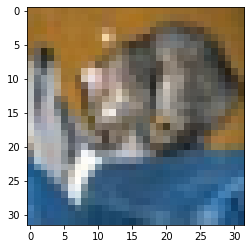

In [37]:
import pkg_resources as pk
import matplotlib.pyplot as plt
import numpy as np

fn = pk.resource_filename("finn.qnn-data", "cifar10/cifar10-test-data-class3.npz")
x = np.load(fn)["arr_0"]
x = x.reshape(3, 32,32).transpose(1, 2, 0)
plt.imshow(x)

Recall that we partitioned our original network into a parent graph that contained the non-synthesizable nodes and a child graph that contained the bulk of the network, which we turned into a bitfile. The only operator left outside the FPGA partition was a `Transpose` to convert NCHW images into NHWC ones. Thus, we can skip the execution in the parent as long as we ensure our image has the expected data layout, which we have done above.

In [7]:
import numpy as np
from finn.core.onnx_exec import execute_onnx

model = ModelWrapper(join(build_dir, EXPORT_NAME + "_deploy.onnx"))
iname = model.graph.input[0].name
oname = model.graph.output[0].name
ishape = model.get_tensor_shape(iname)
test_input = np.load(join(EXPORT_NAME, 'test_input.npy'))
print(test_input.dtype, test_input.shape)
print(test_input)
test_input = np.expand_dims(test_input, 0)
print(test_input.shape)

input_dict = {iname: test_input}
ret = execute_onnx(model, input_dict, True)
print('dupal')

uint8 (224, 224, 3)
[[[ 98 100 101]
  [ 97  99 100]
  [ 95  97  98]
  ...
  [221 237 249]
  [220 235 245]
  [219 234 243]]

 [[ 96  98  99]
  [ 94  96  97]
  [ 91  92  93]
  ...
  [224 240 252]
  [222 238 250]
  [222 237 248]]

 [[ 93  95  97]
  [ 90  92  94]
  [ 86  87  89]
  ...
  [226 244 255]
  [225 242 254]
  [225 241 253]]

 ...

 [[223 236 252]
  [223 236 252]
  [223 236 252]
  ...
  [160 127 114]
  [159 127 113]
  [159 126 113]]

 [[223 234 251]
  [223 234 251]
  [223 234 251]
  ...
  [153 123 111]
  [156 127 114]
  [158 130 117]]

 [[223 233 250]
  [223 233 250]
  [223 233 250]
  ...
  [145 119 107]
  [152 128 116]
  [158 134 122]]]
(1, 224, 224, 3)
dupal


In [11]:
the_result = ret[oname]
the_result = the_result.transpose(0, 3, 1, 2)
print(the_result.dtype)
print(the_result.shape)
# print(the_result[0, 0])
# sys.exit()


mul = np.load(join(EXPORT_NAME, 'Mul_0_param0.npy'))
# add = np.load(join(EXPORT_NAME, 'Add_0_param0.npy'))
the_result = the_result * mul
# the_result = the_result + add
print(the_result[0, 0])
diffs = test_output.detach().numpy() - the_result
nonzeros = np.nonzero(diffs)
print(nonzeros)
print(np.unique(diffs))

float32
(1, 64, 112, 112)
[[0.8470589  0.23529413 0.         ... 1.         1.         1.        ]
 [1.         0.35686275 0.         ... 0.27450982 0.27450982 1.        ]
 [1.         0.4784314  0.         ... 0.27450982 0.27450982 1.        ]
 ...
 [0.27450982 0.27450982 0.27450982 ... 0.3372549  0.3372549  1.        ]
 [0.27450982 0.27450982 0.27450982 ... 0.43921572 0.3372549  1.        ]
 [0.27450982 0.27450982 0.27450982 ... 0.7058824  0.1137255  1.        ]]
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27]), array([  5,   9,   9,  13,  14,  14,  15,  17,  18,  19,  72, 101]), array([14, 14, 36, 31, 31, 33, 34, 30, 29, 32, 96, 73]))
[0.         0.00392157]


We see that the network correctly predicts this as a class 3 ("cat"). 

### Validating the Accuracy on a PYNQ Board <a id='validation'></a>

All the command line prompts here are meant to be executed with `sudo` on the PYNQ board, so we'll use a workaround (`echo password | sudo -S command`) to get that working from this notebook running on the host computer.

**Ensure that your PYNQ board has a working internet connecting for the next steps, since some there is some downloading involved.**

To validate the accuracy, we first need to install the [`dataset-loading`](https://github.com/fbcotter/dataset_loading) Python package to the PYNQ board. This will give us a convenient way of downloading and accessing the MNIST dataset.


Command to execute on PYNQ:

```pip3 install git+https://github.com/fbcotter/dataset_loading.git@0.0.4#egg=dataset_loading```

In [ ]:
! ssh {options} -t {username}@{ip} -p {port} 'echo {password} | sudo -S pip3 install git+https://github.com/fbcotter/dataset_loading.git@0.0.4#egg=dataset_loading'

We can now use the `validate.py` script that was generated together with the driver to measure top-1 accuracy on the CIFAR-10 dataset.

Command to execute on PYNQ:

`python3.6 validate.py --dataset cifar10 --batchsize 1000`

In [ ]:
! ssh {options} -t {username}@{ip} -p {port} 'cd {target_dir_pynq}; echo {password} | sudo -S python3.6 validate.py --dataset cifar10 --batchsize 1000'

We see that the final top-1 accuracy is 84.19%, which is very close to the 84.22% reported on the [BNN-PYNQ accuracy table in Brevitas](https://github.com/Xilinx/brevitas/tree/master/brevitas_examples/bnn_pynq). 